In [1]:
from utils import create_individual_kernel
from models import customSNet_0, customSNet_1
from spike_encoding import encode_to_spikes_TCs

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
from scipy.ndimage import convolve1d
from scipy.signal.windows import exponential, gaussian
from scipy.signal import square, ShortTimeFFT
from scipy.signal import stft, istft
from scipy.io import wavfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import spikingjelly.clock_driven as cd
import spikingjelly.datasets as sjds
# from spikingjelly.clock_driven import neuron, encoding, functional, layer, surrogate
from spikingjelly.activation_based import neuron, layer, learning

import torchvision.transforms as transforms

import IPython.display as ipd
from tqdm.notebook import tqdm

## download prepare and inspect data

tain_set:
 Dataset({
    features: ['file', 'audio', 'label', 'is_unknown', 'speaker_id', 'utterance_id'],
    num_rows: 51093
})
shape of train_set:  (51093, 6)
torch.Size([64, 16000]) torch.Size([64])
tensor(21)


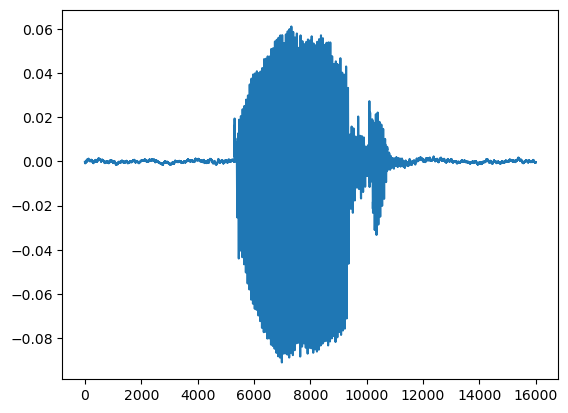

In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader
#from spikingjelly.activation_based import neuron, functional, surrogate, layer
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

from datasets import load_dataset
# import torchaudio

# data = load_dataset('google/speech_commands', 'v0.01', split=['train','test'], trust_remote_code=True)
train_set = load_dataset('google/speech_commands', 'v0.01', split='train', trust_remote_code=True)
test_set = load_dataset('google/speech_commands', 'v0.01', split='test', trust_remote_code=True)


from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder

# inspect the dataset
print("tain_set:\n", train_set)
print("shape of train_set: ", train_set.shape)

# train_set = data['train']
# train_set = torchaudio.datasets.SPEECHCOMMANDS(root='C:/Users/wasse/hello', download=True, subset='training')
# test_set = torchaudio.datasets.SPEECHCOMMANDS(root='C:/Users/wasse/hello', download=True, subset='testing')

max_length = 16000  # or your desired length
# Assume `labels` contains the string labels from your dataset
# all_labels = [item[2] for item in train_set] 
all_labels = train_set['label']
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(all_labels)


def collate_fn(batch):
    max_length = 16000
    # waveforms, labels = zip(*[(item[0].squeeze()[:max_length], item[2]) for item in batch])
    waveforms, labels = zip(*[(torch.tensor(item['audio']['array'][:max_length]) , item['label'])
                              for item in batch])
    # Ensure each waveform is 1D before padding
    waveforms = [waveform if waveform.ndim == 1 else waveform.mean(dim=0) for waveform in waveforms]

    #print("Shapes before padding:", [w.shape for w in waveforms])  # Add this line

    waveforms_padded = pad_sequence(waveforms, batch_first=True, padding_value=0)

    labels = label_encoder.transform(labels)  # Encode the labels as integers

    labels = torch.tensor(labels)
    #print('done')
    return waveforms_padded, labels


train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, collate_fn=collate_fn, drop_last=True)

# show samples
sample_batch = next(iter(train_loader))
# reinstialize the train_loader to get the first batch
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, collate_fn=collate_fn, drop_last=True)

# inspect one sample and its label
print(sample_batch[0].shape, sample_batch[1].shape)
print(sample_batch[1][0])
plt.plot(sample_batch[0][0].numpy())

# # play the audio
# import IPython.display as ipd
# import scipy.io.wavfile
# ipd.Audio(sample[0][0].numpy(), rate=16000)
# scipy.io.wavfile.write('sample.wav', 16000, sample[0][0].numpy())

## tuning curves, encode raw audio to spikes 

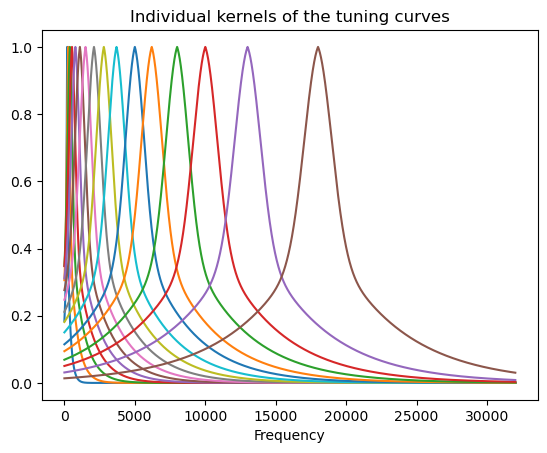

In [4]:
sr = 16000
wave_length = 16000
# spike trains with individual kernels
params = [
    (200, 40, 200),
    (520, 104, 280),
    (840, 168, 390),
    (1160, 232, 540),
    (1480, 296, 780),
    (1800, 360, 1100),
    (2120, 424, 1500),
    (2440, 488, 2100),
    (2760, 552, 2800),
    (3080, 616, 3700),
    (3400, 680, 5000),
    (3720, 744, 6200),
    (4040, 808, 8000),
    (4360, 872, 10000),
    (4680, 936, 13000),
    (5000, 1000, 18000)
]
kernels = [create_individual_kernel(wave_length*2 ,*p) for p in params]
for k in kernels:
    plt.plot(k)
plt.title("Individual kernels of the tuning curves")
plt.xlabel("Frequency")
plt.show()

In [5]:
sample_inputs = sample_batch[0]
print(sample_inputs.shape)
sample_spikes, specs, spec_fr = encode_to_spikes_TCs(sample_inputs,
                                                              kernels,
                                                              spec_method='mel',
                                                              spike_prob_scale=2)

torch.Size([64, 16000])


(64, 16, 64)
(16, 64)


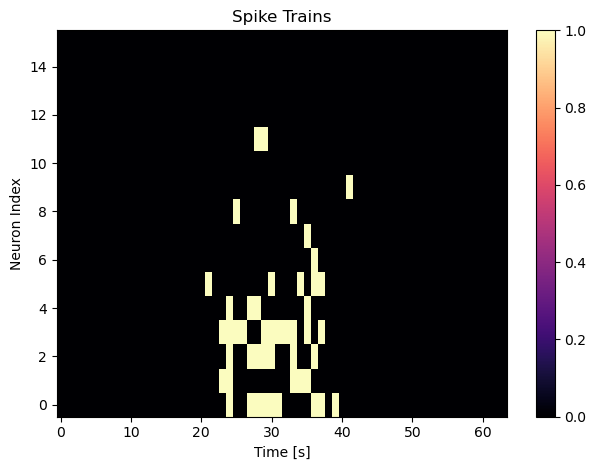

In [6]:
# inspect the spike trains
print(sample_spikes.shape)
print(sample_spikes[0].shape)
plt.imshow(sample_spikes[0], aspect='auto', origin='lower', cmap='magma')
plt.title('Spike Trains')
plt.xlabel('Time [s]')
plt.ylabel('Neuron Index')
plt.colorbar()

plt.tight_layout()
plt.show()

In [ ]:
# old versio with bug fixed and dimensions set to 16 to fit with tuning curves
from models import customSNet_0
import snntorch as snn
from snntorch import functional as SF
from tqdm.notebook import tqdm


num_classes = 35
num_steps = 20
model = customSNet_0(num_steps = num_steps, beta = 0.9, threshold=1.0, spike_grad=snn.surrogate.fast_sigmoid(slope=25), num_class=num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()
sr = 16000  # Number of time steps to simulate
batch_size = 64
train_loss_hist = []
train_accu_hist = []
train_accu_hist_temp = []

n_epochs = 2

iterCount = 0
for epoch in tqdm(range(n_epochs), desc='Epoch', total=n_epochs, leave=True):
    for inputs, labels in tqdm(train_loader, desc='Iteration', total=len(train_loader), leave=False):
        optimizer.zero_grad()
        spikes, _, _  = encode_to_spikes_TCs(inputs, kernels, sr,
                                             spec_method='mel', spike_prob_scale=1.0)
        # convert to torch tensor
        if isinstance(spikes, np.ndarray):
            spikes = torch.tensor(spikes, dtype=torch.float32)
        spike_input= spikes.unsqueeze(1)

        model.train()
        spk_rec, mem_rec = model(spike_input)
        labels = labels.long()
        loss_val = torch.zeros((1), dtype=torch.float)
        for step in tqdm(range(num_steps), desc='Time step', total=num_steps, leave=False):
            loss_val += loss_fn(mem_rec[step], labels)

        # Gradient calculation + weight update
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        avg_loss = loss_val.item()/len(train_loader)
        train_loss_hist.append(loss_val.item())
        acc = SF.accuracy_rate(spk_rec, labels)
        acc2 = SF.accuracy_temporal(spk_rec, labels)
        train_accu_hist.append(acc)
        train_accu_hist_temp.append(acc2)
        iterCount +=1
    print(f' Epoch: {epoch} | Train Loss: {train_loss_hist[-1]:.3f} | Avg Loss: {avg_loss:.3f} | Accuracy: {train_accu_hist[-1]:.3f} | Accuracy: {train_accu_hist_temp[-1]:.3f} | Iteration: {iterCount}')

In [ ]:
# updated version with batch norm and decaying learning rate
from models import customSNet_1
import torch
import torch.nn as nn
import torch.optim as optim
import snntorch as snn
from torch.optim import lr_scheduler

# Hyperparameters
num_steps = 20
beta = 0.9
num_class = 35
learning_rate = 0.001
num_epochs = 10  # Adjust based on your needs

# Initialize model, loss, optimizer, and scheduler
model = customSNet_1(num_steps=num_steps, beta=beta, num_class=num_class)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)


# Example Training Loop with Validation
for epoch in tqdm(range(num_epochs), desc='Epoch', total=num_epochs, leave=True):
    model.train()
    running_loss = 0.0
    for data, labels in tqdm(train_loader, desc='Iteration', total=len(train_loader), leave=False):
        spikes, _, _  = encode_to_spikes_TCs(inputs, kernels, sr,
                                    spec_method='mel', spike_prob_scale=1.0)
        if isinstance(spikes, np.ndarray):
            spikes = torch.tensor(spikes, dtype=torch.float32)
            
        spike_input = spikes.unsqueeze(1)

        optimizer.zero_grad()
        output, _ = model(spike_input)
        # Aggregate outputs over time steps, e.g., mean
        output_mean = output.mean(dim=0)
        labels = labels.long()
        loss = loss_fn(output_mean, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * spike_input.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    
    # Validation phase
    model.eval()
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            spikes, _, _  = encode_to_spikes_TCs(inputs, kernels, sr,
                                    spec_method='mel', spike_prob_scale=1.0)
            if isinstance(spikes, np.ndarray):
                spikes = torch.tensor(spikes, dtype=torch.float32)
            spike_input = spikes.unsqueeze(1)
            output, _ = model(spike_input)
            output_mean = output.mean(dim=0)
            preds = output_mean.argmax(dim=1)
            labels = labels.long()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_accuracy = val_correct / val_total
    
    # Step the scheduler
    scheduler.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}, Learning Rate: {scheduler.optimizer.param_groups[0]['lr']:.6f}")